In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-11 19:39:51.749319: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:39:52.457171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## VGG16

In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
    
vgg_base.trainable = False  

set_trainable = False  

for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  


vgg_model = Sequential()  
  
vgg_model.add(vgg_base)  
  
vgg_model.add(Flatten())  

vgg_model.add(Dense(200, activation='relu'))  
  
vgg_model.add(Dense(6, activation='softmax')) 

2024-04-11 19:40:28.943032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:40:28.951111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 19:40:28.951367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 200)               5017800   
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 19733694 (75.28 MB)
Trainable params: 5019006 (19.15 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
from tensorflow.keras.optimizers import Adam
#compiling 
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
import time
# Record the start time of training
start_time = time.time()

In [10]:
# Train the model
epochs = 10

#Training
history_2 = vgg_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


2024-04-11 19:40:46.779157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-11 19:40:47.736966: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 527.18MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 19:40:47.740384: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 527.18MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-11 19:40:47.743650: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 527.18MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gain

53/53 [==============================] - 46s 801ms/step - loss: 1.6799 - accuracy: 0.4887 - val_loss: 1.1779 - val_accuracy: 0.5286
Epoch 2/10
53/53 [==============================] - 42s 791ms/step - loss: 0.8267 - accuracy: 0.6869 - val_loss: 0.9603 - val_accuracy: 0.6262
Epoch 3/10
53/53 [==============================] - 44s 830ms/step - loss: 0.7074 - accuracy: 0.7339 - val_loss: 0.8691 - val_accuracy: 0.7048
Epoch 4/10
53/53 [==============================] - 44s 831ms/step - loss: 0.6186 - accuracy: 0.7607 - val_loss: 0.7554 - val_accuracy: 0.7095
Epoch 5/10
53/53 [==============================] - 45s 850ms/step - loss: 0.5318 - accuracy: 0.7958 - val_loss: 0.7046 - val_accuracy: 0.7119
Epoch 6/10
53/53 [==============================] - 44s 830ms/step - loss: 0.5333 - accuracy: 0.7970 - val_loss: 0.5736 - val_accuracy: 0.7976
Epoch 7/10
53/53 [==============================] - 44s 833ms/step - loss: 0.5053 - accuracy: 0.8024 - val_loss: 0.6464 - val_accuracy: 0.7357
Epoch 8/10

In [11]:
# Record the training end time
end_time = time.time()

In [12]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 502.75700783729553 seconds


In [13]:
pd.DataFrame(history_2.history)

,loss,accuracy,val_loss,val_accuracy
0,1.679867,0.488690,1.177942,0.528571
1,0.826732,0.686905,0.960325,0.626190
2,0.707384,0.733929,0.869138,0.704762
3,0.618638,0.760714,0.755410,0.709524
4,0.531788,0.795833,0.704636,0.711905
5,0.533311,0.797024,0.573570,0.797619
6,0.505288,0.802381,0.646389,0.735714
7,0.418220,0.844643,0.687158,0.747619
8,0.398100,0.843452,0.628465,0.766667
9,0.453420,0.823810,0.581330,0.764286


In [14]:
import joblib

joblib.dump(history_2.history,'history_VGG_0.001lr.pkl')
history_CNN2 = joblib.load('history_VGG_0.001lr.pkl')

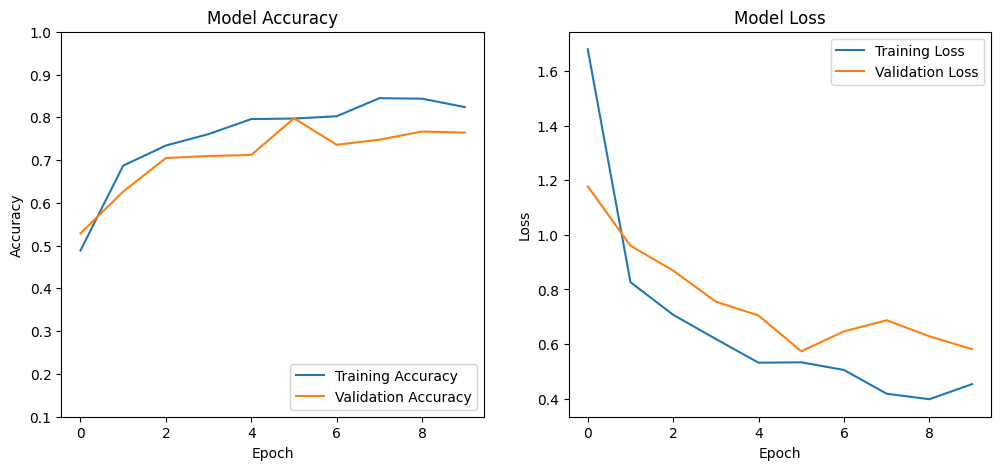

In [15]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['accuracy'])
plt.plot(history_CNN2['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [16]:
vgg_model.save('VGG16_model_0.001lr.h5')

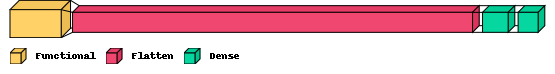

In [28]:
import visualkeras

visualkeras.layered_view(vgg_model,  legend=True)